# Importación de librerías

In [1]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification, make_blobs


from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import (
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC

# Pregunta 1


## Primera parte

Construya un modelo de ensamble basado en stacking, que consisten en una capa
de clasificadores débiles basada en bagging, que luego son combinados por un
clasificador fuerte (a diferencia de Random Forest, donde la combinación se hace
por voto de mayoría). Entrene este modelo en un conjunto de datos sintético,
utilizando las funciones de scikit-learn vistas en clases.

### Creación de la data sintética

In [2]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_clusters_per_class=1,
    n_classes=3,
    random_state=42,
)

### Separación

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Visualización

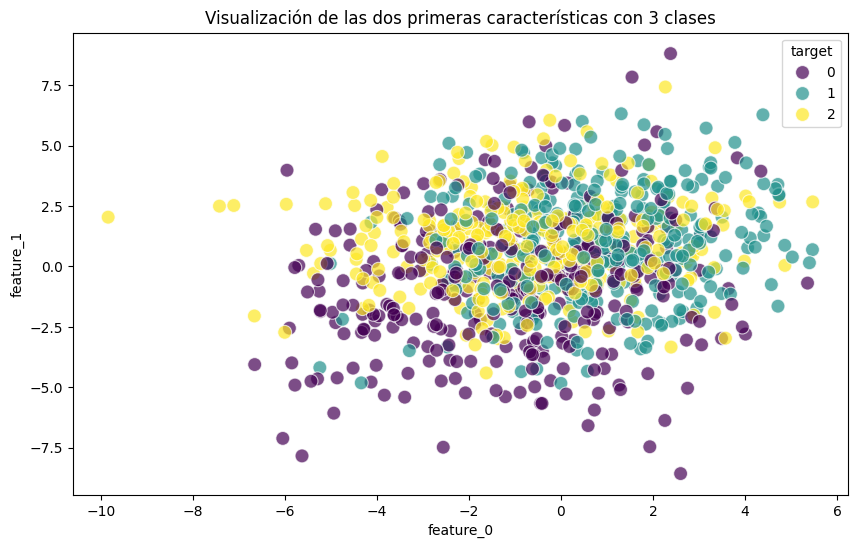

In [4]:
# Convertir a DataFrame para una visualización más fácil
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(20)])
df["target"] = y

# Visualización de las dos primeras características
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="feature_0",
    y="feature_1",
    hue="target",
    palette="viridis",
    s=100,
    alpha=0.7,
)
plt.title("Visualización de las dos primeras características con 3 clases")
plt.show()

### Creación del modelo de ensamble

#### Construcción de los clasificadores débiles

In [5]:
estimador_debil_1 = DecisionTreeClassifier(max_depth=1)
estimador_debil_2 = GaussianNB()
estimado_fuerte = SVC(kernel="rbf", C=1, gamma="scale", random_state=42)

#### Bagging

In [6]:
estimadores = [
    (
        "dtc",
        BaggingClassifier(
            estimator=estimador_debil_1, n_estimators=10, random_state=42
        ),
    ),
    (
        "gnb",
        BaggingClassifier(
            estimator=estimador_debil_2, n_estimators=10, random_state=42
        ),
    ),
]

#### Staking

In [7]:
clasificador_stacking = StackingClassifier(
    estimators=estimadores, final_estimator=estimado_fuerte, cv=5
)

### Entrenamiento

In [8]:
clasificador_stacking.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('dtc',
                                BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                                  random_state=42)),
                               ('gnb',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=42))],
                   final_estimator=SVC(C=1, random_state=42))

### Predicción

In [9]:
y_pred = clasificador_stacking.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [10]:
print(f"Accuracy del modelo de Stacking: {accuracy:.4f}")

Accuracy del modelo de Stacking: 0.8500


### Matriz de confusión

In [11]:
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        xticklabels=classes,
        yticklabels=classes,
        cmap="Blues",
    )

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

    plt.show()

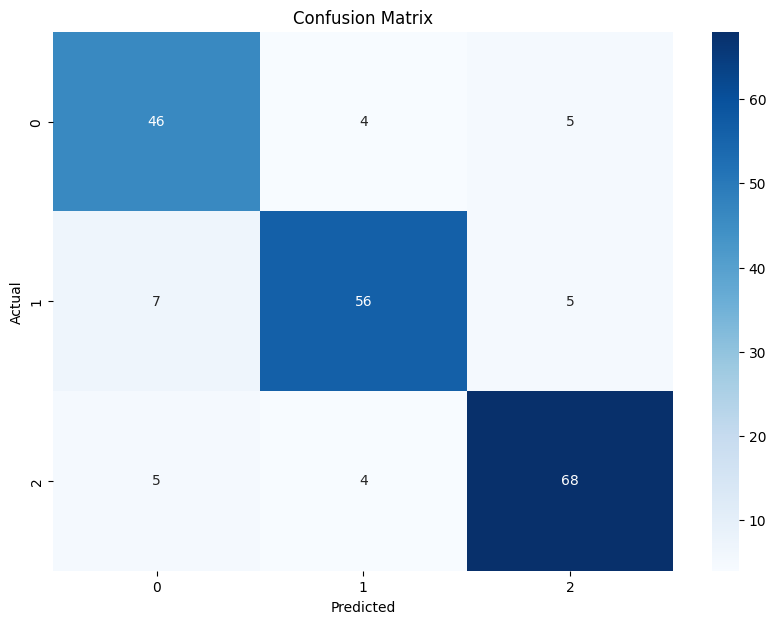

In [12]:
clasese = np.unique(y_test)
plot_confusion_matrix(y_test, y_pred, np.unique(y_test), title="Confusion Matrix")

## Segunda Parte

Aunque esta parte del ejercicio únicamente requería realizar el stacking, decidimos ir un paso más allá. Realizamos un análisis exhaustivo del conjunto de datos, procedimos a limpiar y estandarizar los datos, y finalmente construimos el modelo.

Hemos elegido el dataset de "Obesity Levels" disponible en Kaggle, que se puede encontrar en el siguiente enlace: [Obesity Levels Dataset](https://www.kaggle.com/datasets/fatemehmehrparvar/obesity-levels)

### Descripción del dataset

El dataset "Obesity Levels" contiene información sobre varios factores relacionados con la obesidad. Las columnas del dataset incluyen tanto datos numéricos como categóricos. La información contenida en el dataset incluye datos demográficos y de estilo de vida de los individuos, como la frecuencia del consumo de alimentos, la actividad física y otros hábitos que pueden influir en el nivel de obesidad.

Columnas del dataset:
- Gender: Género del individuo (categórico).
- Age: Edad del individuo (numérico).
- Height: Altura del individuo en metros (numérico).
- Weight: Peso del individuo en kilogramos (numérico).
- family_history_with_overweight: Historial familiar de sobrepeso (categórico).
- FAVC: Frecuencia del consumo de alimentos grasos (categórico).
- FCVC: Frecuencia del consumo de vegetales (numérico).
- NCP: Número de comidas principales al día (numérico).
- CAEC: Consumo de alimentos entre comidas (categórico).
- SMOKE: Fuma o no (categórico).
- CH2O: Consumo diario de agua (numérico).
- SCC: Monitorea las calorías que consume (categórico).
- FAF: Frecuencia de actividad física por semana (numérico).
- TUE: Tiempo de uso de dispositivos electrónicos por día (numérico).
- CALC: Frecuencia del consumo de alcohol (categórico).
- MTRANS: Medio de transporte que utiliza (categórico).
- NObeyesdad: Nivel de obesidad (categórico, y será la columna a predecir).


### Que queremos predecir

La tarea de predicción que realizaremos es clasificar el nivel de obesidad del individuo en función de las características proporcionadas. La columna a predecir es NObeyesdad, que contiene la clasificación del nivel de obesidad.

### Descarga del dataset

In [13]:
url = "https://drive.google.com/uc?id=1l-ywysTBLSfLZN3oNhbd7ihyjAP7Xdek"

output = "obesity_levels.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1l-ywysTBLSfLZN3oNhbd7ihyjAP7Xdek
To: /content/obesity_levels.csv
100%|██████████| 264k/264k [00:00<00:00, 51.7MB/s]


'obesity_levels.csv'

### Dataset

In [14]:
df = pd.read_csv("obesity_levels.csv")
df.shape

(2111, 17)

#### Visualización de dataset

In [15]:
df.head()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


#### Descripción de los datos

In [16]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


#### Visualización de info

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

Al revisar el dataset, nos dimos cuenta de que la columna Age tiene valores de edades flotantes, lo cual es inconsistente con la mayor parte de los datos (ejemplo: 21.34 años de edad), lo mismo ocurre con otras columnas como CH2O, FAF, ....etc. Por lo tanto, procedimos a convertir las columnas flotantes en enteros, a excepción de Height y Weight.

In [18]:
for column in df.columns:
    if df[column].dtype == "float64" and column != "Height" and column != "Weight":
        df[column] = df[column].astype(int)

In [19]:
df

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21,Female,1.620000,64.000000,no,no,2,3,no,no,2,yes,0,1,Sometimes,Public_Transportation,Normal_Weight
1,21,Female,1.520000,56.000000,Sometimes,no,3,3,yes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,23,Male,1.800000,77.000000,Frequently,no,2,3,no,no,2,yes,2,1,Sometimes,Public_Transportation,Normal_Weight
3,27,Male,1.800000,87.000000,Frequently,no,3,3,no,no,2,no,2,0,Sometimes,Walking,Overweight_Level_I
4,22,Male,1.780000,89.800000,Sometimes,no,2,1,no,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20,Female,1.710730,131.408528,Sometimes,yes,3,3,no,no,1,yes,1,0,Sometimes,Public_Transportation,Obesity_Type_III
2107,21,Female,1.748584,133.742943,Sometimes,yes,3,3,no,no,2,yes,1,0,Sometimes,Public_Transportation,Obesity_Type_III
2108,22,Female,1.752206,133.689352,Sometimes,yes,3,3,no,no,2,yes,1,0,Sometimes,Public_Transportation,Obesity_Type_III
2109,24,Female,1.739450,133.346641,Sometimes,yes,3,3,no,no,2,yes,1,0,Sometimes,Public_Transportation,Obesity_Type_III


#### Visualizando la data

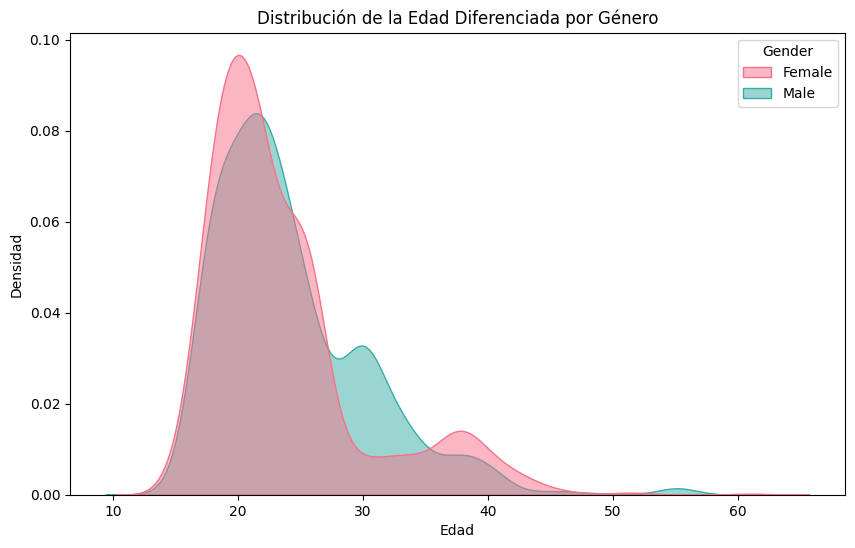

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df,
    x="Age",
    hue="Gender",
    fill=True,
    common_norm=False,
    palette="husl",
    alpha=0.5,
)
plt.title("Distribución de la Edad Diferenciada por Género")
plt.xlabel("Edad")
plt.ylabel("Densidad")
plt.show()

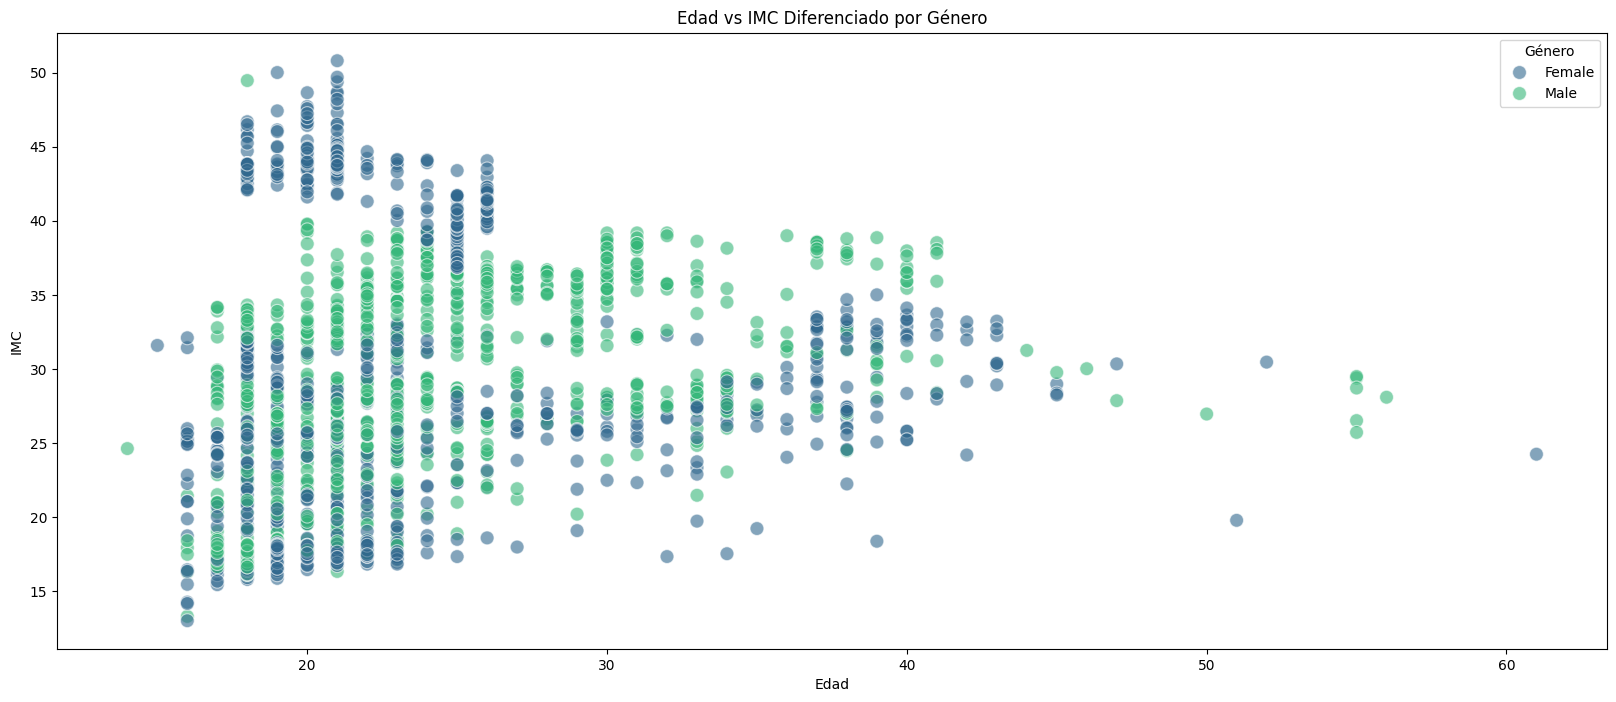

In [21]:
# Cálculo del IMC (Índice de Masa Corporal)
df["BMI"] = df["Weight"] / (df["Height"] ** 2)

plt.figure(figsize=(20, 8))
sns.scatterplot(
    x="Age", y="BMI", hue="Gender", data=df, palette="viridis", s=100, alpha=0.6
)
plt.title("Edad vs IMC Diferenciado por Género")
plt.xlabel("Edad")
plt.ylabel("IMC")
plt.legend(title="Género")
plt.show()

Quiero aclarar que para este gráfico me apoyé en gran medida en lo presentado en el siguiente [notebook](https://www.kaggle.com/code/keremkarayaz/obesity-analysis-and-accuracy-96?scriptVersionId=173547029&cellId=16). Me pareció muy interesante lo que pude visualizar en él, por lo tanto, decidí adoptarlo y usarlo.

### Selección de columnas a usar para la clasificación

#### Columnas a Utilizar:

**Gender**: Género del individuo (categórico).

**Age**: Edad del individuo (numérico).

**Height**: Altura del individuo en metros (numérico).

**Weight**: Peso del individuo en kilogramos (numérico).

**family_history_with_overweight**: Historial familiar de sobrepeso (categórico).

**FAVC**: Frecuencia del consumo de alimentos grasos (categórico).

**FCVC**: Frecuencia del consumo de vegetales (numérico).

**NCP**: Número de comidas principales al día (numérico).

**CAEC**: Consumo de alimentos entre comidas (categórico).

**CH2O**: Consumo diario de agua (numérico).

**FAF**: Frecuencia de actividad física por semana (numérico).

**TUE**: Tiempo de uso de dispositivos electrónicos por día (numérico).


#### Columnas a Eliminar:
1. **SCC**
2. **MTRANS**
3. **CALC**
4. **SMOKE**

#### Justificación:
- **SCC**: La decisión de eliminar esta columna se basa en la necesidad de simplificar el modelo. Monitorizar las calorías es un hábito que podría no ser consistente o suficientemente variado en la muestra de datos proporcionada, lo que hace que su contribución a la variabilidad del modelo sea limitada.
- **MTRANS**: Aunque podría ser un indicativo de niveles de actividad física, la gran mayoría de datos se concentran en 'Public_Transportation', lo que limita su variabilidad y relevancia. Las categorías con pocos datos como 'Motorbike' y 'Bike' no aportan suficiente información discriminante.
- **CALC**: La distribución desequilibrada de esta variable, con la mayoría de las respuestas en 'Sometimes' y muy pocas en 'Always', sugiere que no es un predictor robusto de la obesidad.
- **SMOKE**: Dada la abrumadora mayoría de participantes que no fuman, esta variable muestra una baja variabilidad que podría no aportar diferencia significativa en un modelo predictivo.

In [22]:
# Eliminación de columnas
df = df.drop(["SCC", "MTRANS", "CALC", "SMOKE"], axis=1)

### Tratamiento de valores nulos


In [23]:
df.isnull().sum()

Age                               0
Gender                            0
Height                            0
Weight                            0
FAVC                              0
FCVC                              0
NCP                               0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
NObeyesdad                        0
BMI                               0
dtype: int64

**Este dataset no presenta valores nulos**

### Tratamiento de otras columnas en el dataset

In [24]:
numeric_columns = df.select_dtypes(exclude="object").columns
print(numeric_columns)
print("*" * 100)
categorical_columns = df.select_dtypes(include="object").columns
print(categorical_columns)

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI'], dtype='object')
****************************************************************************************************
Index(['Gender', 'FAVC', 'family_history_with_overweight', 'CAEC',
       'NObeyesdad'],
      dtype='object')


Quiero destacar que, para desarrollar esta sección, me basé en un interesante [notebook](https://www.kaggle.com/code/pavankumarmantha/eda-and-prediction-with-95-accuracy#Data-Preprocessing-and-Pipelining) del cual aprendí muchísimo. No sabía lo útil que podía ser utilizar pipelines para la estandarización y codificación del dataset, e incluso para el uso de PCA.

In [25]:
# Definir el pipeline para las características numéricas
numeric_features = Pipeline([("scaling", StandardScaler(with_mean=True))])

# Definir el pipeline para las características categóricas
categorical_features = Pipeline([("encoding", OneHotEncoder())])

# Definir el ColumnTransformer usando make_column_selector
processing = ColumnTransformer(
    [
        ("numeric", numeric_features, make_column_selector(dtype_include="number")),
        (
            "categorical",
            categorical_features,
            make_column_selector(dtype_include="object"),
        ),
    ]
)

# Definir el pipeline que incluye el PCA
pca_pipeline = Pipeline(
    [("processing", processing), ("pca", PCA(n_components=2, random_state=12))]
)

### Partición de datos


#### Selección de los features y el target

In [26]:
X = df.drop(columns=["NObeyesdad"])
y = df["NObeyesdad"]

#### División de los datos en conjuntos de entrenamiento y prueba

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Para dividir nuestro conjunto de datos en partes para entrenar y probar nuestros modelos, elegimos una división de 70/30. Esto significa que usamos el 70% de los datos para entrenar el modelo y el resto, el 30%, para probar qué tan bien funciona realmente. Esta es una forma bastante común de hacer las cosas porque te da suficiente información para que el modelo aprenda bien, pero también te deja con suficiente para probarlo de manera justa y ver cómo se desempeña con datos nuevos.

Además, usamos algo llamado stratify, que básicamente asegura que nuestras muestras de entrenamiento y prueba reflejen las proporciones reales de las clases del conjunto completo de datos.

### Análisis con PCA


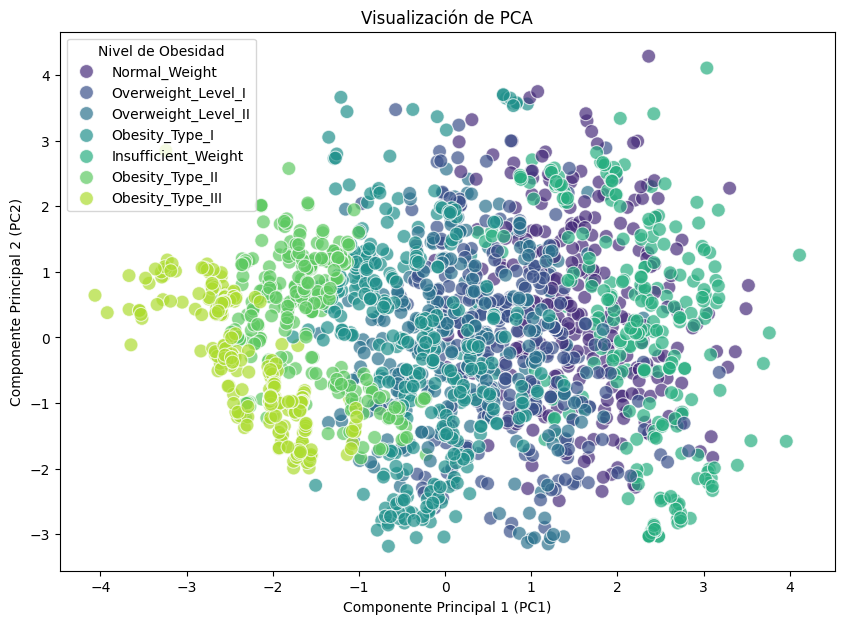

In [28]:
# Ajustar el pipeline y transformar los datos con PCA
X_pca = pca_pipeline.fit_transform(X)

# Convertir los datos transformados por PCA a un DataFrame para graficar
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["NObeyesdad"] = y.values

# Graficar los componentes principales utilizando seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", y="PC2", hue="NObeyesdad", data=pca_df, palette="viridis", s=100, alpha=0.7
)
plt.title("Visualización de PCA")
plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.legend(title="Nivel de Obesidad")
plt.show()

**Conclusión del Gráfico**

Aunque hay algunos grupos que parecen estar superpuestos, esto nos dice que, con las info que tenemos, no es fácil separar a la gente en diferentes niveles de obesidad solo con ver estas dos medidas principales.

Los que están en los extremos del gráfico, como los muy obesos o los de peso insuficiente, tienden a estar un poco más apartados que los demás. Esto podría sugerir que son bastante distintos en ciertas características comparados con el resto.

### Creación de diferentes combinaciones de clasificadores

In [29]:
combinaciones = [
    (
        "modelo_1",
        BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=10,
            random_state=42,
        ),
        BaggingClassifier(estimator=GaussianNB(), n_estimators=10, random_state=42),
        SVC(kernel="rbf", C=1, gamma="scale", random_state=42),
    ),
    (
        "modelo_2",
        BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=10,
            random_state=42,
        ),
        BaggingClassifier(
            estimator=KNeighborsClassifier(), n_estimators=10, random_state=42
        ),
        RandomForestClassifier(n_estimators=100, random_state=42),
    ),
    (
        "modelo_3",
        BaggingClassifier(estimator=GaussianNB(), n_estimators=10, random_state=42),
        BaggingClassifier(
            estimator=KNeighborsClassifier(), n_estimators=10, random_state=42
        ),
        GradientBoostingClassifier(n_estimators=100, random_state=42),
    ),
]

### Entrenamiento

In [30]:
trained_models = []

for i, (
    nombre,
    clasificador_debil_1,
    clasificador_debil_2,
    clasificador_fuerte,
) in enumerate(combinaciones, 1):
    estimadores = [
        ("clf1", clasificador_debil_1),
        ("clf2", clasificador_debil_2),
    ]

    clasificador_stacking = StackingClassifier(
        estimators=estimadores, final_estimator=clasificador_fuerte, cv=5
    )
    model = Pipeline(
        [
            ("processing", processing),  # Preprocesamiento si es necesario
            ("stacking", clasificador_stacking),
        ]
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    trained_models.append((nombre, model))

### Accuracy de los modelos en el split de test

In [31]:
def plot_confusion_matrix(y_true, y_pred, classes, ax, title="Confusion Matrix"):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=classes)
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        xticklabels=classes,
        yticklabels=classes,
        cmap="Blues",
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

Accuracy de modelo modelo_1 en el split de test: 83.75%
Accuracy de modelo modelo_2 en el split de test: 79.02%
Accuracy de modelo modelo_3 en el split de test: 91.80%


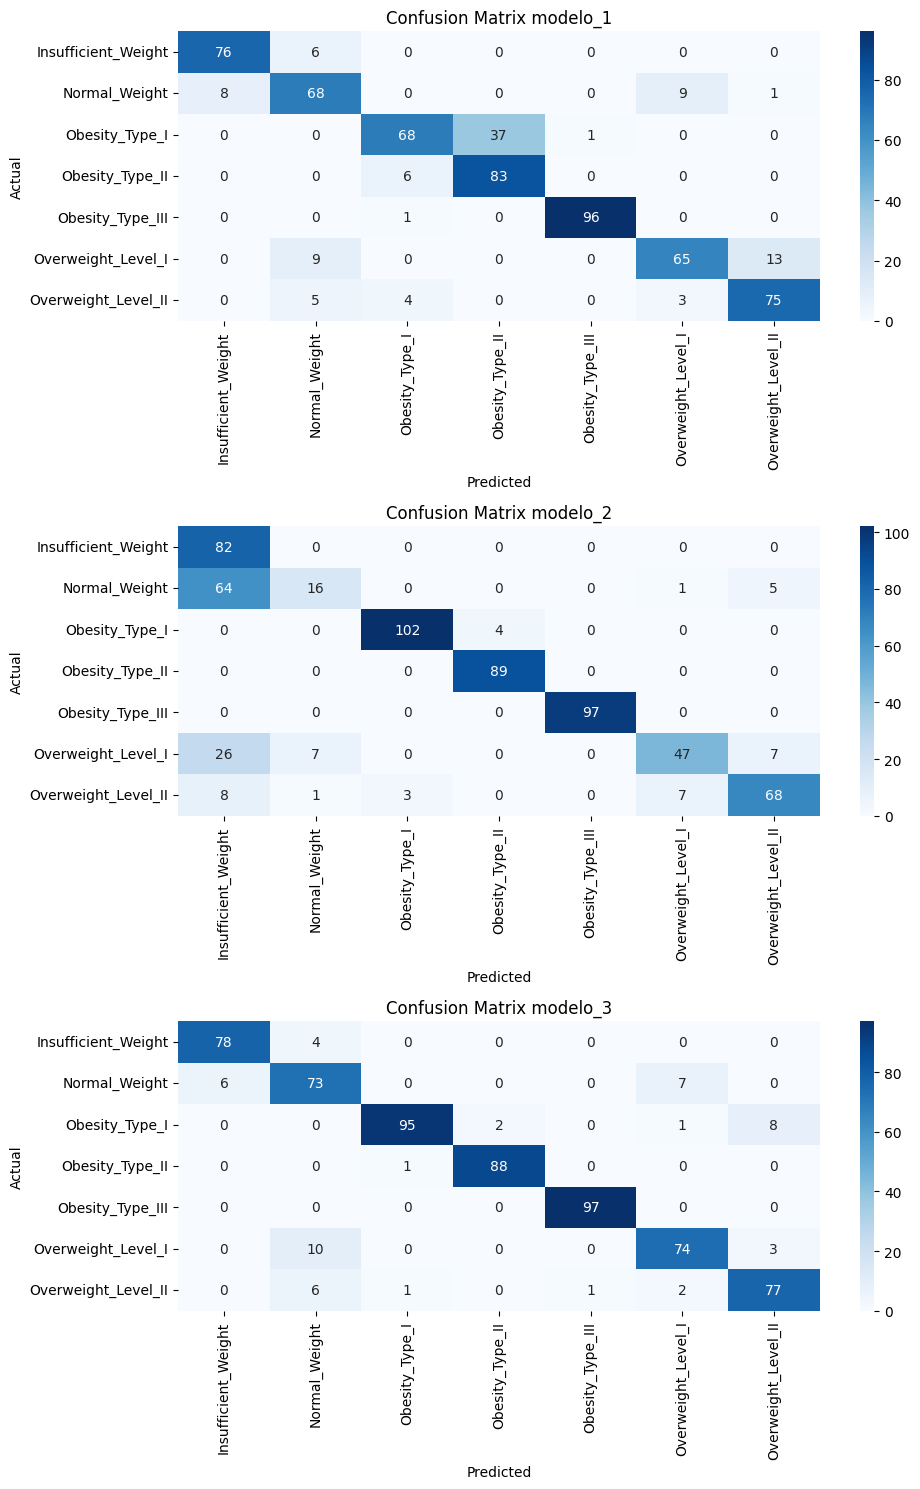

In [32]:
fig, axes = plt.subplots(
    nrows=len(trained_models), ncols=1, figsize=(10, 5 * len(trained_models))
)

class_names = sorted(np.unique(y_test))

if len(trained_models) == 1:
    axes = [axes]  # Make it iterable

for (name, model), ax in zip(trained_models, axes):
    # Predice con el modelo
    y_pred = model.predict(X_test)

    # Calcula la precisión y muestra los resultados
    test_accuracy = model.score(X_test, y_test)
    print(f"Accuracy de modelo {name} en el split de test: {test_accuracy * 100:.2f}%")

    # Plotea la matriz de confusión
    plot_confusion_matrix(
        y_test, y_pred, class_names, ax=ax, title=f"Confusion Matrix {name}"
    )

plt.tight_layout()
plt.show()

# Pregunta 2

### Generación del conjunto de datos sintético

In [33]:
X, y = make_blobs(n_samples=40, centers=2, random_state=42, cluster_std=1.5)

### Entrenamiento

In [34]:
svm = SVC(kernel="linear")
svm.fit(X, y)

SVC(kernel='linear')

### Obtener los vectores de soporte

In [35]:
vectores_de_soporte = svm.support_vectors_

### Visualización del conjunto de datos y el hiperplano

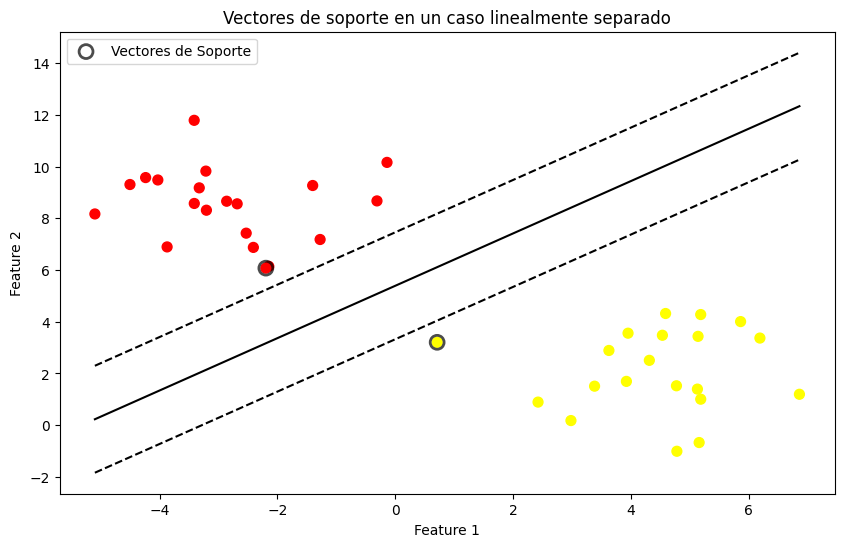

Número de vectores de soporte: 2


In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
plt.scatter(
    vectores_de_soporte[:, 0],
    vectores_de_soporte[:, 1],
    s=100,
    alpha=0.7,
    facecolors="none",
    edgecolors="k",
    linewidths=2,
    label="Vectores de Soporte",
)

# Obtener los coeficientes del hiperplano
w = svm.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(min(X[:, 0]), max(X[:, 0]))
yy = a * xx - (svm.intercept_[0]) / w[1]

# Líneas del margen
margin = 1 / np.sqrt(np.sum(w**2))
yy_down = yy + a * margin
yy_up = yy - a * margin

plt.plot(xx, yy, "k-")
plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")
plt.title("Vectores de soporte en un caso linealmente separado")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

print(f"Número de vectores de soporte: {len(vectores_de_soporte)}")

### Justificación

En el gráfico que generamos, podemos observar que los vectores de soporte son los puntos más cercanos al hiperplano separador. En este caso bidimensional (2 características), vemos que el SVM necesita al menos 3 vectores de soporte (2 características + 1) para definir el margen.

El número de vectores de soporte en general es al menos n+1, donde n es la dimensionalidad del espacio de características. Esto asegura que el SVM tiene suficiente información para definir el hiperplano y los márgenes de manera óptima.

Con este ejemplo, hemos demostrado gráficamente y justificado la cantidad mínima de vectores de soporte necesarios para un SVM lineal en un caso linealmente separable.


# Pregunta 3

Aquí se genera un dataset que es dificilmente separable linealmente debido a la Class_sep, que en el fondo, lo que determina esto, es que tan cerca estan las clases una de otras, l que influye directamente en el solapamiento que puedan llegar a tener unas con otras, haciendo mas difil la separacion lineal (o eventualmente casi imposible)

### Generación del conjunto de datos sintético

In [37]:
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0.5,
    random_state=42,
)

### Entrenamiento

In [38]:
svm = SVC(kernel="linear")
svm.fit(X, y)

SVC(kernel='linear')

### Obtener los vectores de soporte

In [39]:
support_vectors = svm.support_vectors_

### Visualización del conjunto de datos y el hiperplano

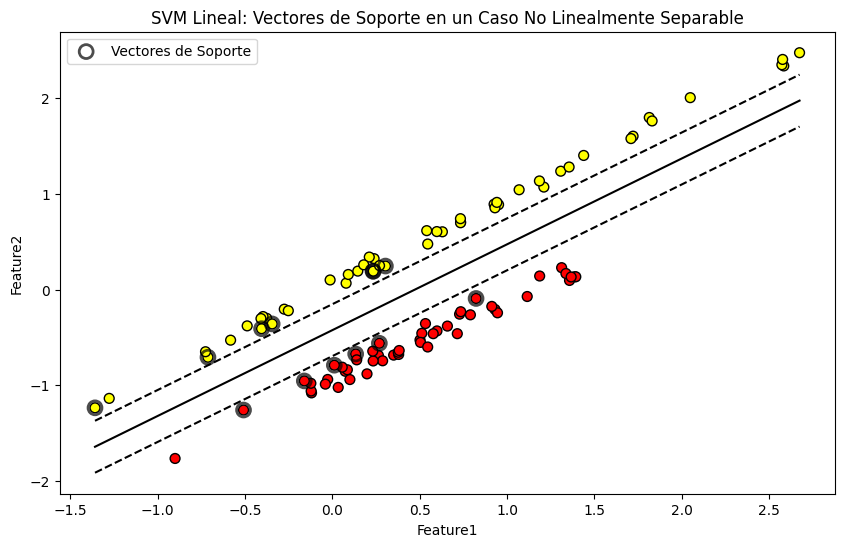

Cantidad de vectores de soporte: 13


In [40]:
# Crear un DataFrame con los datos
df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
df["Label"] = y

# Obtener los coeficientes del hiperplano
w = svm.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(min(X[:, 0]), max(X[:, 0]))
yy = a * xx - (svm.intercept_[0]) / w[1]

# Líneas del margen
margin = 1 / np.sqrt(np.sum(w**2))
yy_down = yy + a * margin
yy_up = yy - a * margin

# Graficar los datos y los vectores de soporte
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="autumn", s=50, edgecolors="k")
plt.scatter(
    support_vectors[:, 0],
    support_vectors[:, 1],
    s=100,
    alpha=0.7,
    facecolors="none",
    edgecolors="k",
    linewidths=2,
    label="Vectores de Soporte",
)
plt.title("SVM Lineal: Vectores de Soporte en un Caso No Linealmente Separable")
plt.plot(xx, yy, "k-")
plt.plot(xx, yy_down, "k--")
plt.plot(xx, yy_up, "k--")
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.legend()
plt.show()

print(f"Cantidad de vectores de soporte: {len(support_vectors)}")

# Pregunta 4

A continuación generamos 3 modelos SVM con distintos tipos de Kernel, uno Polinomial, otro RBF y otro Sigmoidal. En la teoría se supone que para los modelos SVM no lineales, estos tres tipos de kernel debiesen tender a dar menores vectores de soporte que el lineal, esto debido al traslape de los datos y, por lo tanto, a la dificultad de aproximarse a los vectores de soporte, pero debido a las caracteirticas y la naturaleza del dataset, el kernel lineal se ajusta mejor que los otros, por lo menos en cuanto a cantidad de vectores de soporte.

Cabe aclarar nuevamente que una menor cantidad de vectores de soporte no asegura necesariamente un mejor accuracy del modelo. Ya que si bien una menor cantidad de vectores de sopote implica una menor necesidad de datos para la rediccion, es posible que se este perdiendo cierta "complejidad" de los datos analizados, lo que cual podria llegar a ser importante para futuras modelaciones.

En este caso particular, tenemos que el Kernel Polinomial necesita una mayor cantidad de vectores de soporte (52) que los Kernel RBF y Sigmoidal (22 Cada uno). Esto se debe, nuevamente, a la naturaleza especifica de los datos del Dataset, ya que normalmente se suele dar que el Polinomial se ajusta mejor.

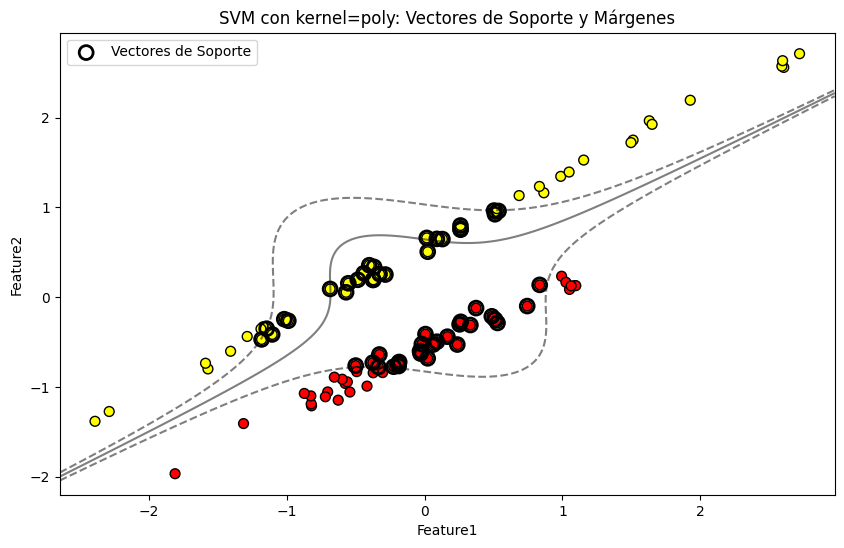

Kernel: poly
Cantidad de vectores de soporte: 52


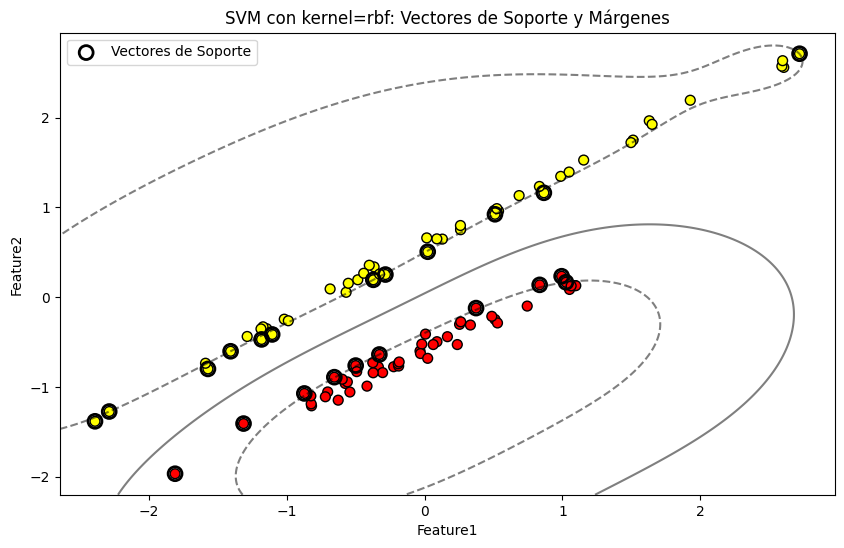

Kernel: rbf
Cantidad de vectores de soporte: 22


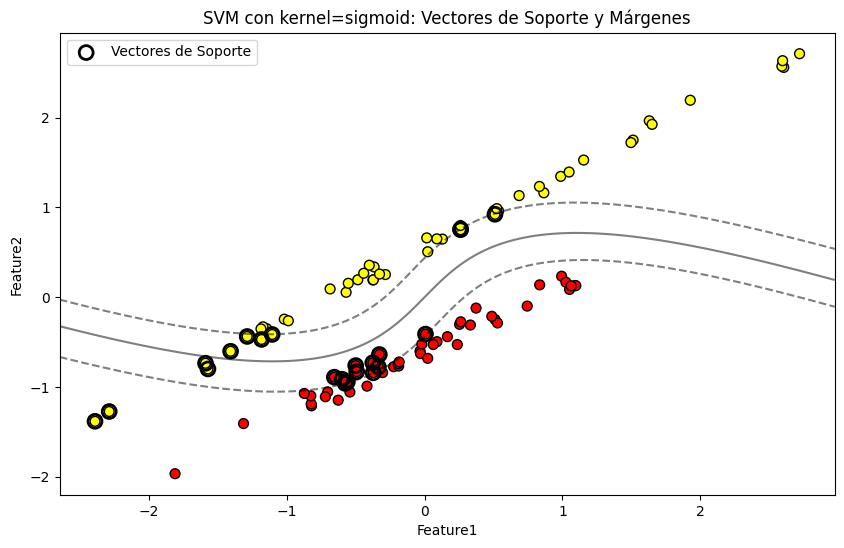

Kernel: sigmoid
Cantidad de vectores de soporte: 22

Cantidad de vectores de soporte por kernel:
poly: 52
rbf: 22
sigmoid: 22


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Generar un dataset no linealmente separable
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0.5,
    random_state=42,
)

# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Crear un DataFrame con los datos
df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
df["Label"] = y

# Definir los diferentes kernels a usar
kernels = ["poly", "rbf", "sigmoid"]
support_vectors_count = {}


# Función para graficar los márgenes de decisión y las líneas de soporte
def plot_svc_decision_boundary(model, ax, plot_support=True):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Crear una cuadrícula para evaluar el modelo
    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 200), np.linspace(ylim[0], ylim[1], 200)
    )
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Graficar la frontera de decisión y los márgenes
    ax.contour(
        xx,
        yy,
        Z,
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )

    # Graficar los vectores de soporte
    if plot_support:
        ax.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            s=100,
            facecolors="none",
            edgecolors="k",
            linewidths=2,
            label="Vectores de Soporte",
        )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


# Entrenar y contar los vectores de soporte para cada kernel
for kernel in kernels:
    svm = SVC(kernel=kernel)
    svm.fit(X, y)
    support_vectors = svm.support_vectors_
    support_vectors_count[kernel] = len(support_vectors)

    # Graficar los datos y los vectores de soporte
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="autumn", s=50, edgecolors="k")
    plot_svc_decision_boundary(svm, ax)
    ax.set_title(f"SVM con kernel={kernel}: Vectores de Soporte y Márgenes")
    ax.set_xlabel("Feature1")
    ax.set_ylabel("Feature2")
    legend = ax.legend()
    plt.show()

    print(f"Kernel: {kernel}")
    print(f"Cantidad de vectores de soporte: {len(support_vectors)}")

# Comparar la cantidad de vectores de soporte
print("\nCantidad de vectores de soporte por kernel:")
for kernel, count in support_vectors_count.items():
    print(f"{kernel}: {count}")